In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers
from keras import backend

In [34]:

def _x(t,data):
    return 0 if t < 0 else data[t]

def x(t,data):
    beta = 0.2
    gamma = 0.1
    tau = 25
    n = 10
    return _x(t-1,data) + (beta*_x(t-tau-1,data))/(1+_x(t-tau-1,data)**n) - gamma*_x(t-1,data)

def mackey_glass_generator():


    N = 2000

    data = np.zeros(N)
    data[0] = 1.5

    for t in range(1,N):
        data[t] = x(t,data)

    return data
def get_train_test_data(x):
    train_set = np.zeros([1000,5])
    train_labels = np.zeros([1000])
    
    for t in range(300,1300):
        train_set[t-300,:] = [x[t-20], x[t-15], x[t-10], x[t-5], x[t]]
        train_labels[t-300] = x[t+5] 

    test_set = np.zeros([200,5])
    test_labels = np.zeros([200])
    
    for t in range(1300,1500):
        test_set[t-1300,:] = [x[t-20], x[t-15], x[t-10], x[t-5], x[t]]
        test_labels[t-1300] = x[t+5] 
        
    return train_set, train_labels, test_set, test_labels

def init_network(num_nodes, lambd):
    if len(num_nodes) < 1:
        return None

    model = Sequential()

    num_layers = len(num_nodes)
    model.add(Dense(num_nodes[0], input_dim=5, kernel_initializer='normal', activation='relu',use_bias=True, activity_regularizer=regularizers.l2(lambd)))
    for i in range(1, num_layers):
        model.add(Dense(num_nodes[i], kernel_initializer='normal', activation='relu', use_bias=True, activity_regularizer=regularizers.l2(lambd)))
    model.add(Dense(1, kernel_initializer='normal', activation='relu', use_bias=True, activity_regularizer=regularizers.l2(lambd)))
    #not sparse data so we use L2 reg
    model.summary()
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='mse',metrics=['MSE'])
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.001, patience=100)
    return model, es

2000


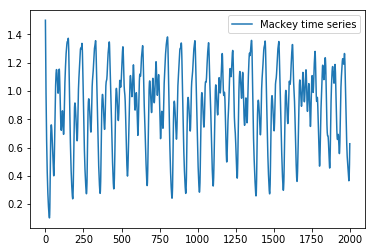

In [35]:
x = mackey_glass_generator()
print(len(x))
t = np.arange(len(x))
plt_A, = plt.plot(t,x, label='Mackey time series')
plt.legend(handles=[plt_A])
plt.show()

Nodes hidden layer:  2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
Epoch 00101: early stopping
MSE training: 0.8934375
MSE val: 0.907838761806488


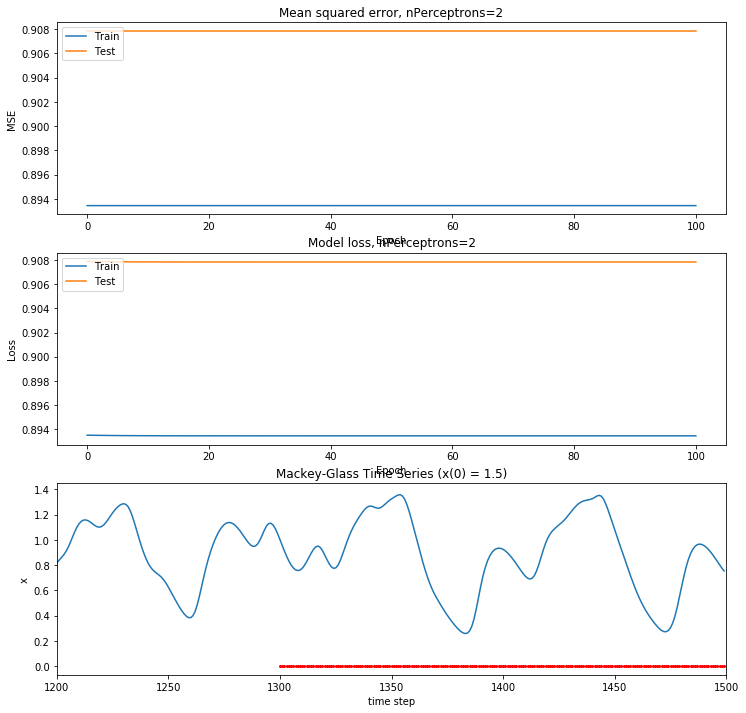

Nodes hidden layer:  4
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
Epoch 00177: early stopping
MSE training: 0.010188537
MSE val: 0.009553594514727592


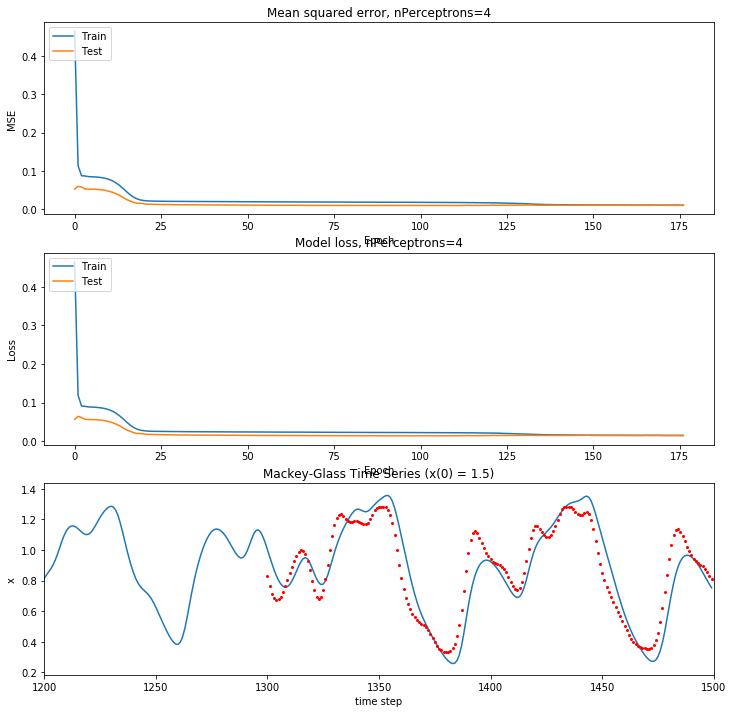

Nodes hidden layer:  6
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________
Epoch 00253: early stopping
MSE training: 0.0016487782
MSE val: 0.0013226238079369068


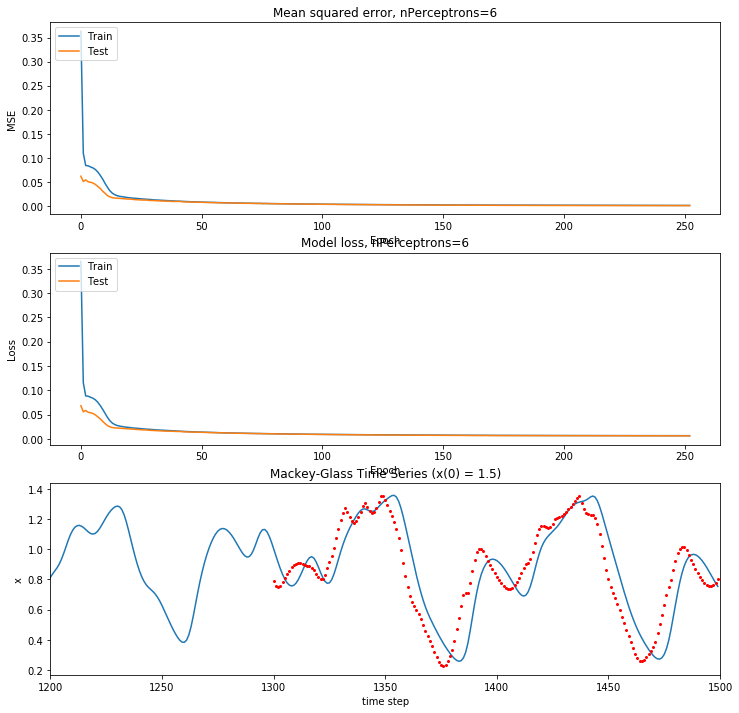

Nodes hidden layer:  8
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 48        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________
Epoch 00214: early stopping
MSE training: 0.009508563
MSE val: 0.009035288356244564


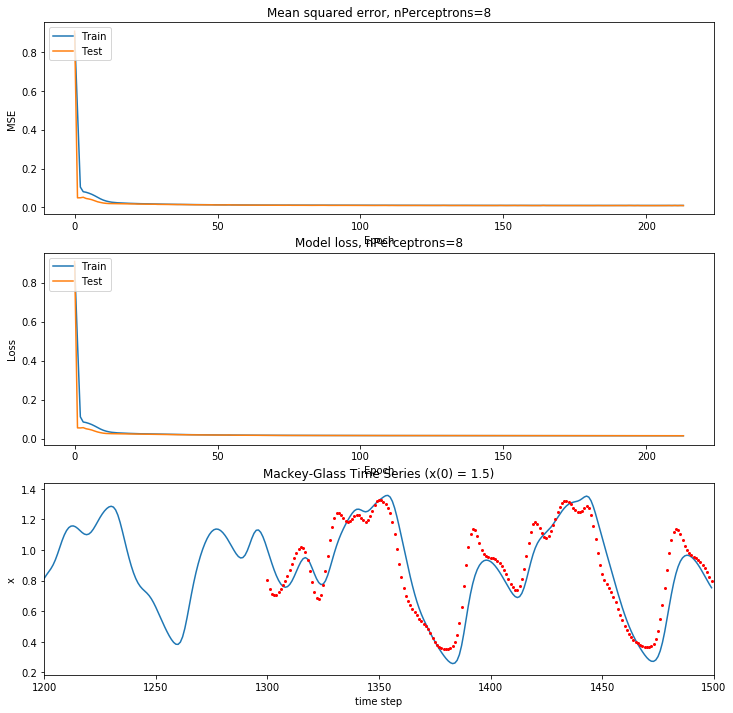

In [20]:
def error_mse(T, Y):
    #return np.sum((T - Y) ** 2) / 2
    return np.mean(((Y-T)**2))

train_set, train_labels, test_set, test_labels = get_train_test_data(x)
nodes_first_layer = [2,4,6,8]

lamb = 0.0
lamb = 1e-4

for k in range(len(nodes_first_layer)):
    print("Nodes hidden layer: ", nodes_first_layer[k])

    #if hidden_nodes_first_layer[j] > hidden_nodes_second_layer[i]:
    model, early_stopping = init_network([nodes_first_layer[k]],lamb)
    history = model.fit(train_set, train_labels, epochs=10000, batch_size=50, validation_split=0.2,  callbacks=[early_stopping], verbose=0)

    predictions = model.predict(test_set, verbose=0)
    print("MSE training:",history.history['MSE'][-1])
    print("MSE val:",history.history['val_MSE'][-1])
        
    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    # Plot training & validation accuracy valuesa
    ax1.plot(history.history['MSE'])
    ax1.plot(history.history['val_MSE'])
    ax1.set_title('Mean squared error, nPerceptrons='+str(nodes_first_layer[k]))
    ax1.set_ylabel('MSE')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss, nPerceptrons='+str(nodes_first_layer[k]))
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Test'], loc='upper left')

    keras.backend.clear_session()
    t = np.arange(301,len(x)-500)
        
    ax3.plot(t,x[301:len(x)-500])
    ax3.plot(range(1300,1500),predictions,'ro',markersize=2)
    ax3.set_xlabel("time step")
    ax3.set_ylabel("x")
    ax3.set_title("Mackey-Glass Time Series (x(0) = 1.5)")
    ax3.set_xlim([1200,1500])
        
    plt.show()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 8)                 48        
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 9         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________
Epoch 00421: early stopping
MSE training: 0.0042303805
MSE val: 0.0040616258047521114


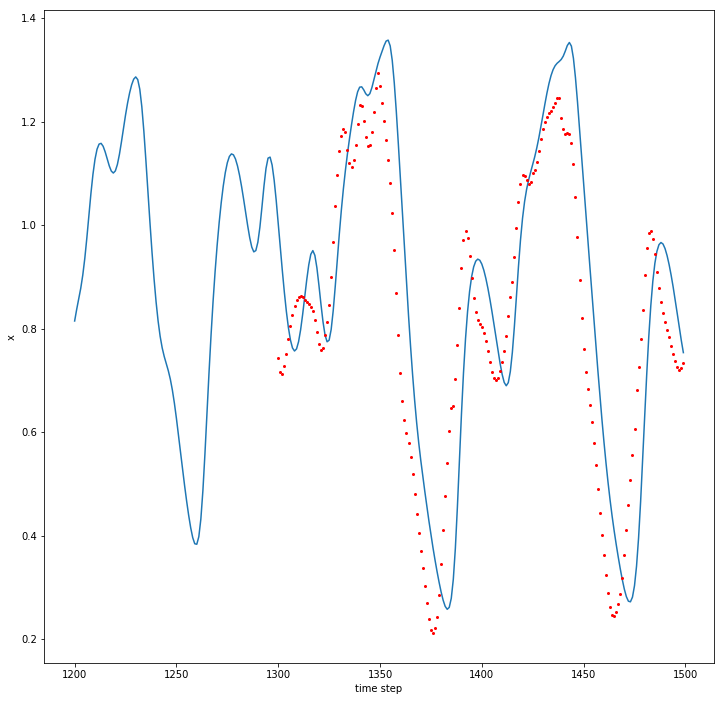

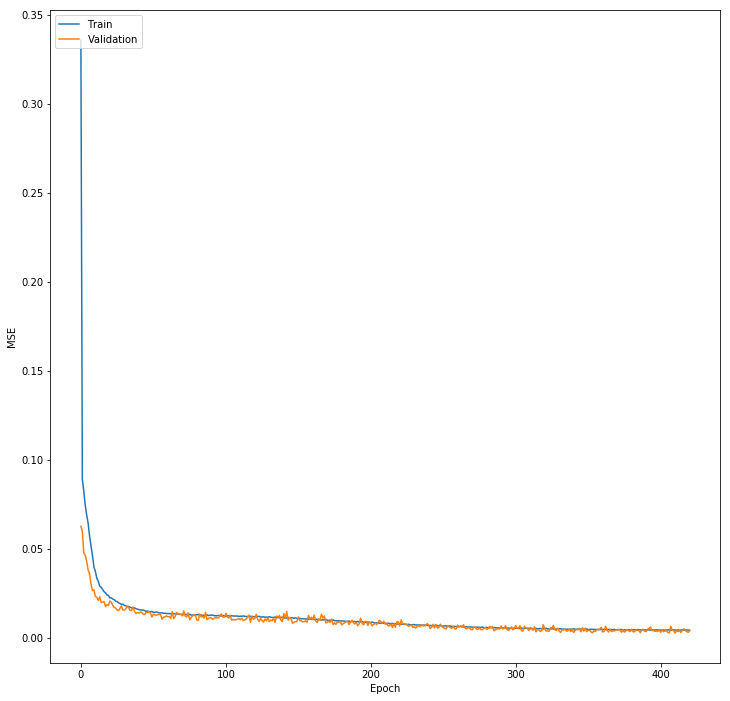

In [56]:
nPerceptron = 8
lamb = 1e-3
model, early_stopping = init_network([nPerceptron],lamb)

history = model.fit(train_set, train_labels, epochs=10000, batch_size=50, validation_split=0.2,  callbacks=[early_stopping], verbose=0)

predictions = model.predict(test_set, verbose=0)

print("MSE training:",history.history['MSE'][-1])
print("MSE val:",history.history['val_MSE'][-1])

fig = plt.figure(figsize=(12,12))
#ax1 = fig.add_subplot(111)
plt.plot()
t = np.arange(1200,len(x)-500)

plt.plot(t,x[1200:len(x)-500])
plt.plot(range(1300,1500),predictions,'ro',markersize=2)
plt.xlabel("time step")
plt.ylabel("x")
plt.savefig("4.3.1_mackie_e2.png")
#plt.set_title("Mackey-Glass Time Series (x(0) = 1.5)")
#print(history.history['MSE'])
fig = plt.figure(figsize=(12,12))
plt.plot(history.history['MSE'])
plt.plot(history.history['val_MSE'])
#plt.plot(np.arange(len(history.history['MSE'])))
#plt.set_title('Mean squared error, nPerceptrons='+str(nodes_first_layer[k]))
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("4.3.1_MSE_e2.png")

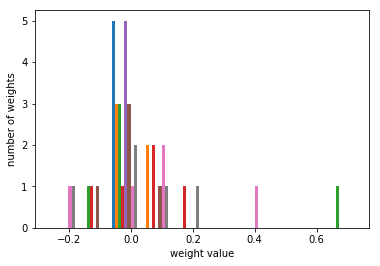

In [57]:
weights, biases = model.layers[0].get_weights()
plt.hist(weights)
plt.xlabel("weight value")
plt.ylabel("number of weights")
plt.savefig('weights1e3')
#plt.title("Weight distribution for 8 nodes, lambda = e-4")